--- 

Reproduce the results from:

Abi Jaber, Illand, and Li (2023). *[The quintic Ornstein-Uhlenbeck volatility model that jointly
calibrates SPX & VIX smiles](https://arxiv.org/pdf/2212.10917)*

---

# Imports

In [1]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
import quintic

sns.set_theme("talk")
mpl.rcParams["figure.figsize"] = (8, 6)
SEED = 1234

## The quintic Ornstein-Uhlenbeck model

$$
\begin{aligned}
    \frac{dS_t}{S_t} &= \sigma_t \left(\rho \, dW_t + \sqrt{1-\rho^2} \, dW_t^\perp\right),  \\
    \\
    \sigma_t &= \sqrt{\xi_0(t)}\frac{p(X_t)}{\sqrt{\mathbb E \left[p(X_t)^2\right]}}, 
    \quad p(x) =\alpha_0 + \alpha_1 x + \alpha_3 x^3 + \alpha_5 x^5,
    \\
    X_t &= \varepsilon^{H-\frac12} \int_0^t e^{-(\frac12-H)\varepsilon^{-1}(t-s)} \, dW_s,
    \quad \varepsilon > 0.
\end{aligned}
$$

## Sanity checks

We check the formula for $\mathbb{E}[p(X_t)^2]$

In [72]:
a0, a1, a3, a5 = np.abs(np.random.randn(4))
sig = 1.0
n_quad = 40
estim = quintic.mean_px_squared(a0=a0, a1=a1, a3=a3, a5=a5, sig=sig, n_quad=n_quad)
theoretical = quintic.mean_px_squared(a0=a0, a1=a1, a3=a3, a5=a5, sig=sig)

n_mc = 2 * 10**6
x = sig * np.random.randn(n_mc)
mc = np.mean((a0 + a1 * x + a3 * x**3 + a5 * x**5) ** 2)

print(f"Quadrature value: {estim:.5f}")
print(f"MC estimate:      {mc:.5f}")
print(f"Theoretical value:   {theoretical:.5f}")

Quadrature value: 5645.47330
MC estimate:      5845.09910
Theoretical value:   5677.98285


## SPX call/put options by Monte Carlo with antithetic and control variates

In [3]:
# TODO: code control variate method to reduce variance

Recall $X_t = \varepsilon^{H-\frac12} \int_0^t e^{-(\frac12-H)\varepsilon^{-1}(t-s)} \, dW_s$

Consider $t_k = k \Delta $, $k=0, \ldots, n$, with $\Delta  = T/n$.

Then, we have the recursion

$$
    X_{t_k} 
    = \varepsilon^{H-\frac12} \int_0^{t_k} e^{-(\frac12-H)\varepsilon^{-1}(t_k-s)} \, dW_s
    = e^{-(\frac12-H)\varepsilon^{-1}\Delta} X_{t_{k-1}} + \delta X_k,
$$

where

$$
\delta X_k = \varepsilon^{H-\frac12} \int_{t_{k-1}}^{t_k} e^{-(\frac12-H)\varepsilon^{-1}(t_k-s)} \, dW_s
\sim \mathcal N \left(0, \mathbb{E}[\delta X_k^2]\right).
$$

and 

$$
\mathbb{E}[\delta X_k^2] = \frac{\varepsilon^{2H}}{1-2H}\left(1 - e^{-(1-2H)\varepsilon^{-1}\Delta}\right).
$$

we need to compute the covariance between $\delta X_k$ 
and $\delta W_k = \int_{t_{k-1}}^{t_k} dW_s = W_{t_k} - W_{t_{k-1}} \sim \mathcal N \left(0, \Delta\right)$.


It is given by

$$
\mathbb{E}[\delta X_k \, \delta W_k]
= \varepsilon^{H-\frac12} \int_{t_{k-1}}^{t_k} e^{-(\frac12-H)\varepsilon^{-1}(t_k-s)} \, ds
= \frac{\varepsilon^{H+\frac12}}{\frac12-H}\left(1 - e^{-(\frac12-H)\varepsilon^{-1}\Delta}\right).
$$

In [3]:
np.random.seed(SEED)
n_steps = 200
n_mc = 1 * 10**5
w1 = quintic.gen_bm_path(n_steps, n_mc)
w1 = np.insert(w1, 0, 0, axis=0)  # W_0 = 0

In [4]:
params = {
    "rho": -0.65,
    "H": -0.1,
    "eps": 1 / 52,
    "a_vec": [0.01, 1, 0.214, 0.227],
}

In [5]:
S0 = 1.0
T = 1 / 12
ks = np.linspace(-0.2, 0.03, 50)  # log-moneyness
Ks = np.exp(ks) * S0  # strikes

In [6]:
T_array_nodes = np.array([0, 0.03, 1 / 12, 2 / 12, 3 / 12, 6 / 12, 12 / 12, 24 / 12])
fv_nodes = np.ones_like(T_array_nodes) * 0.02  # fix fwd variance at 0.02

In [10]:
p_mc, std_mc, imp_mc, imp_mc_upper, imp_mc_lower = quintic.mc_polynomial_fwd_var(
    params=params,
    T=T,
    S0=S0,
    Ks=Ks,
    n_steps=n_steps,
    n_mc=n_mc,
    fv_nodes=fv_nodes,
    T_array_nodes=T_array_nodes,
    w1=w1,
)

In [17]:
impvols = quintic.simulate_quintic_ou(
    params=params,
    xi0=lambda t: 0.02 * np.ones_like(t),
    T=T,
    k=ks,
    n_steps=n_steps,
    n_mc=n_mc,
)

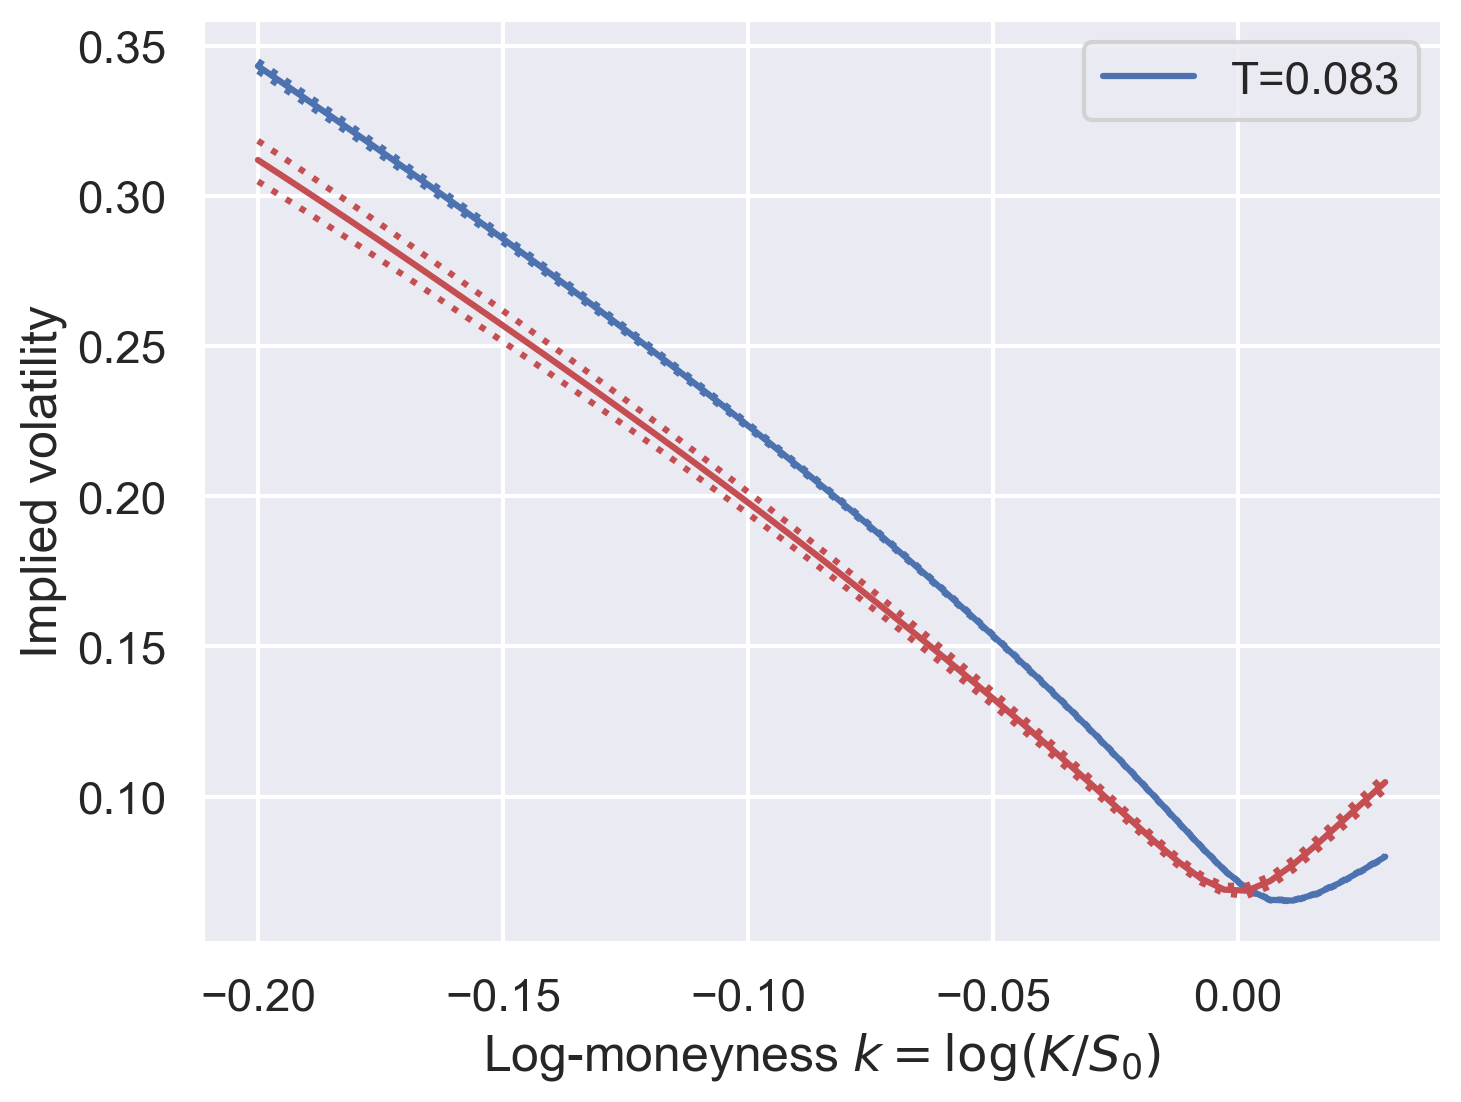

In [18]:
fig, ax = plt.subplots()
ax.plot(ks, imp_mc, "-b", label=f"T={T:.3f}")
ax.plot(ks, imp_mc_upper, ":b")
ax.plot(ks, imp_mc_lower, ":b")
ax.plot(ks, impvols["otm_impvol"], "r-")
ax.plot(ks, impvols["otm_impvol_high"], ":r")
ax.plot(ks, impvols["otm_impvol_low"], ":r")
ax.set_xlabel(r"Log-moneyness $k = \log(K/S_0)$")
ax.set_ylabel("Implied volatility")
ax.legend()
plt.show()

Sanity check on path simulation of $(X_t, V_t, S_t)_{t \in [0,T]}$

In [19]:
X, V, S = quintic.simulate_quintic_ou(
    params=params,
    xi0=lambda t: 0.02 * np.ones_like(t),
    T=T,
    k=ks,
    n_steps=n_steps,
    n_mc=n_mc,
    return_paths=True,
)

In [20]:
S_mean = np.mean(S, axis=1)
V_mean = np.mean(V, axis=1)
X_mean = np.mean(X, axis=1)

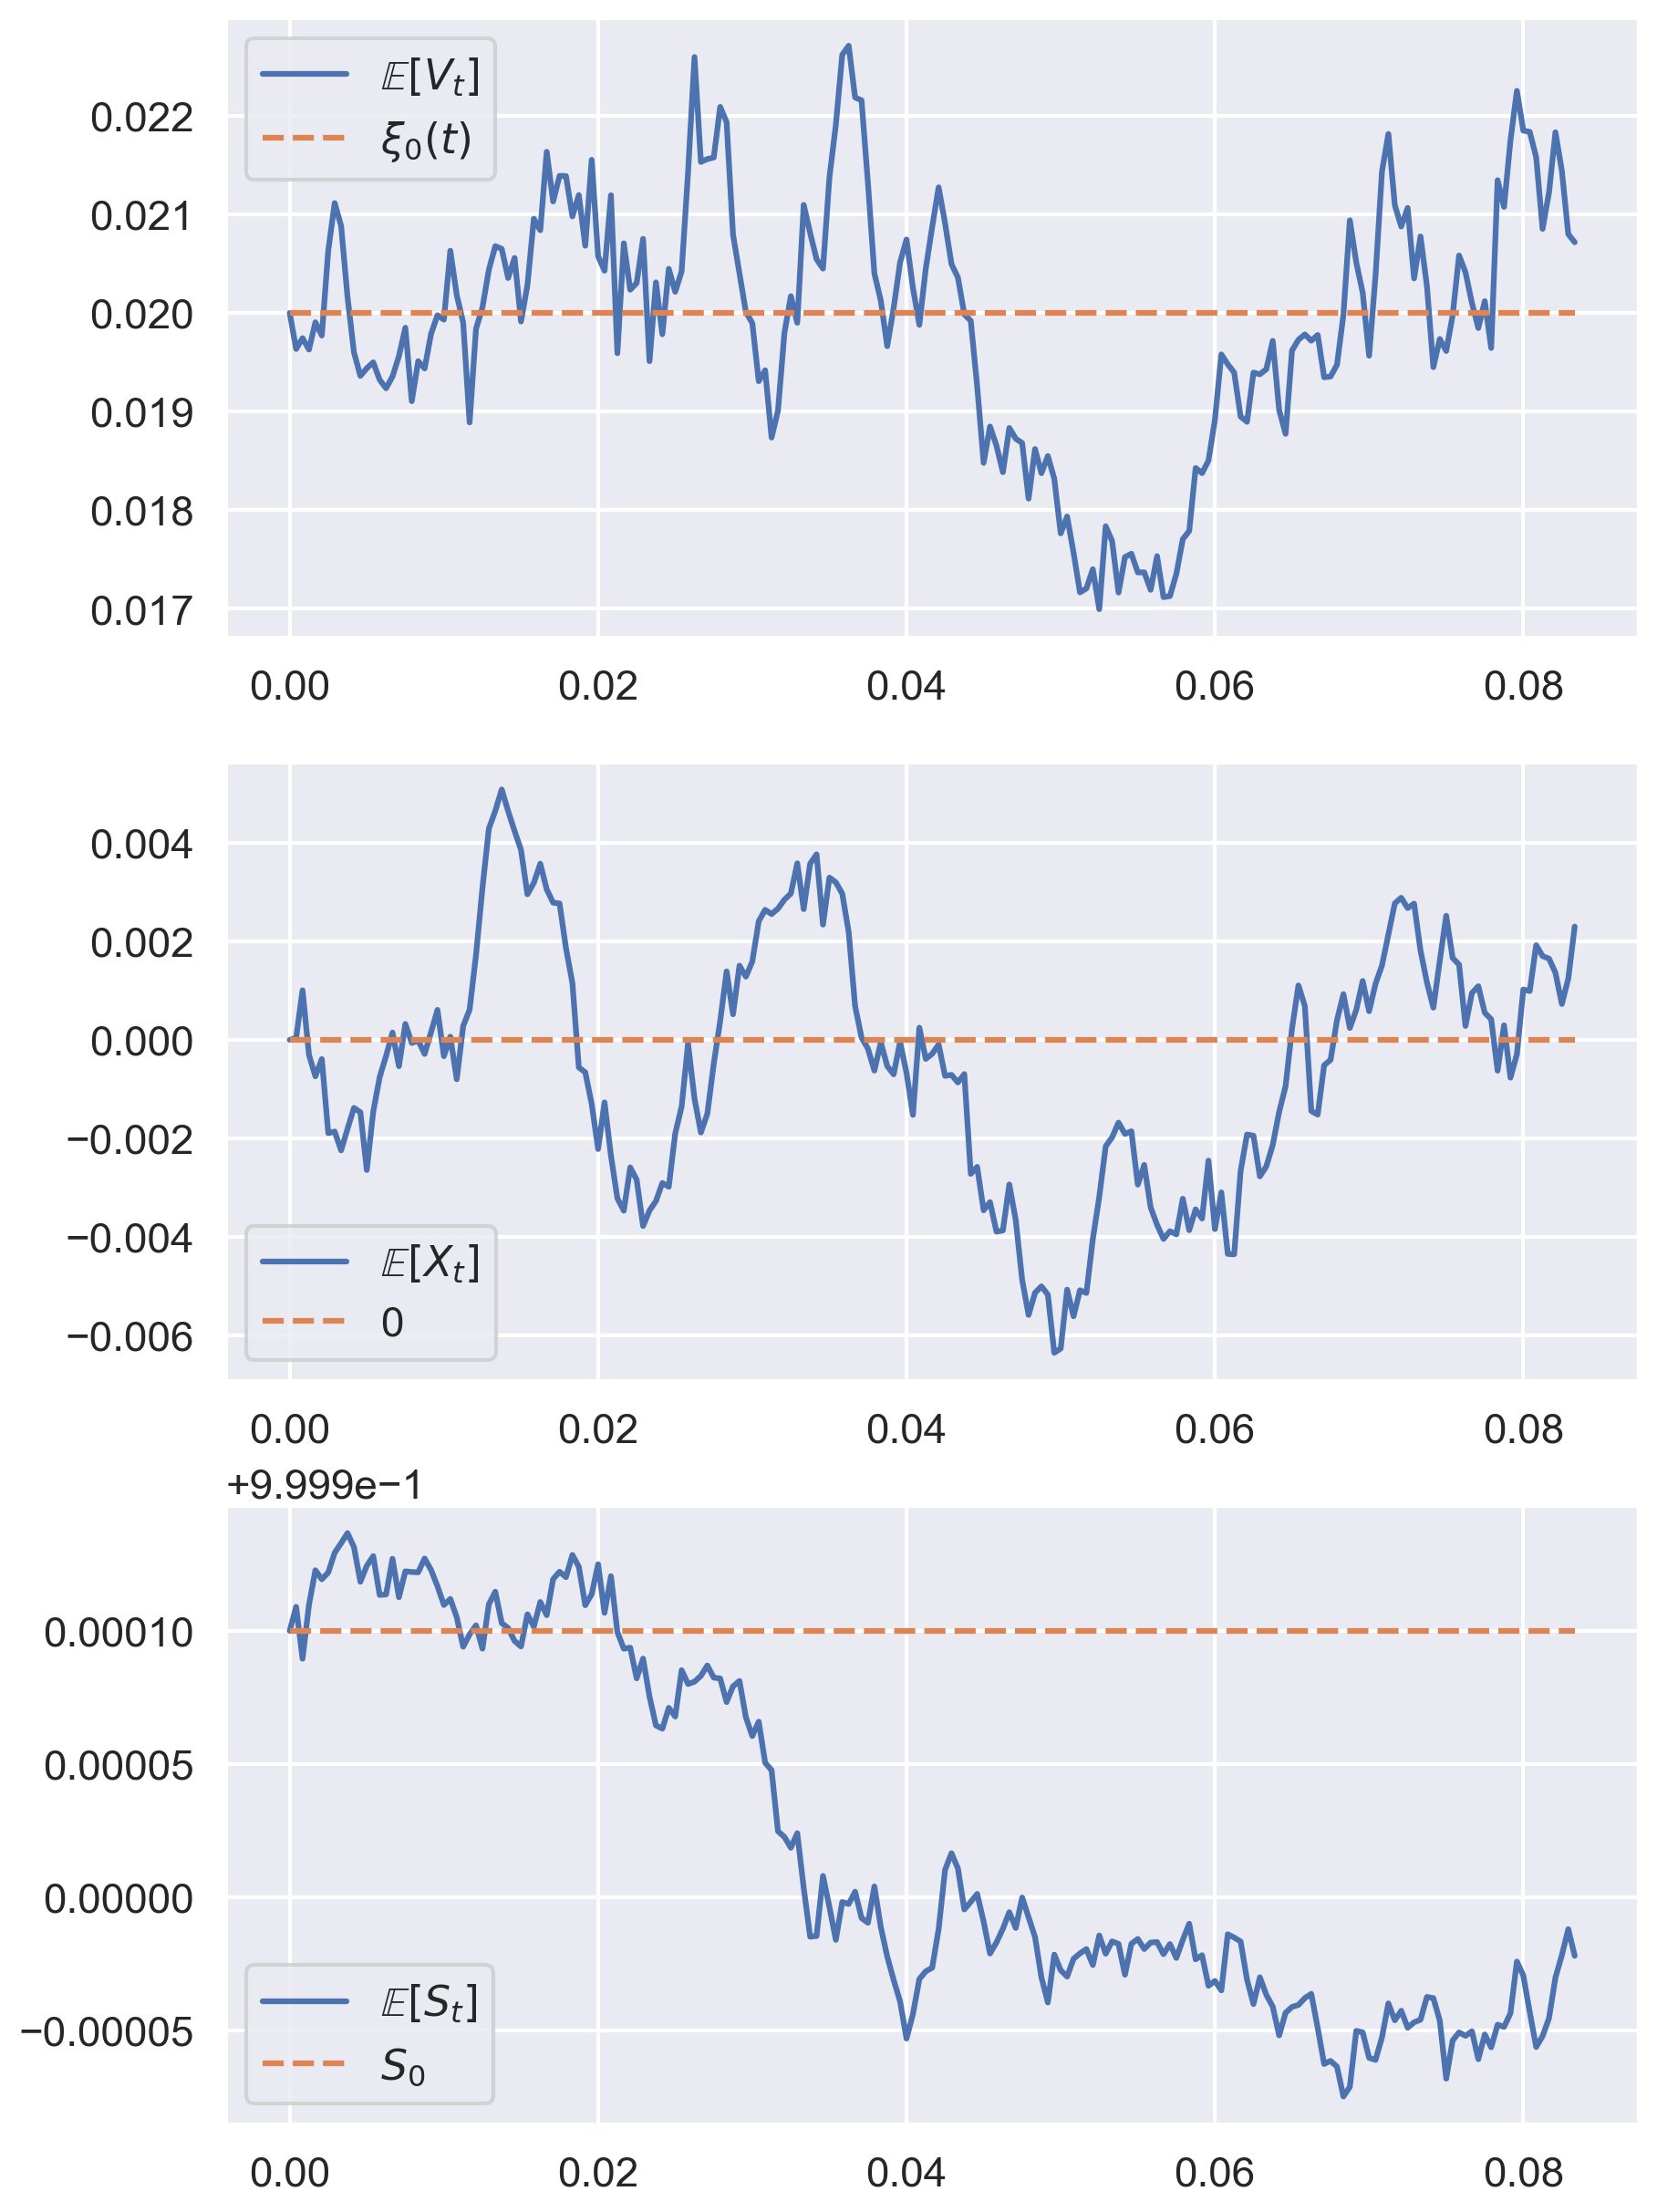

In [21]:
ts = np.linspace(0, T, n_steps + 1)

fig, ax = plt.subplots(3, 1, figsize=(10, 15))
ax[0].plot(ts, V_mean, label=r"$\mathbb{E}[V_t]$")
ax[0].plot(ts, 0.02 * np.ones_like(ts), "--", label=r"$\xi_0(t)$")
ax[0].legend()
ax[1].plot(ts, X_mean, label=r"$\mathbb{E}[X_t]$")
ax[1].plot(ts, 0.0 * ts, "--", label=r"0")
ax[1].legend()
ax[2].plot(ts, S_mean, label=r"$\mathbb{E}[S_t]$")
ax[2].plot(ts, S0 * np.ones_like(ts), "--", label=r"$S_0$")
ax[2].legend()
plt.show()

## VIX call/put options by Gaussian quadrature

In [13]:
# gaussian quadrature
deg_vix = 800
x_org_vix, w_org_vix = np.polynomial.legendre.leggauss(deg_vix)
lb_vix = -8
ub_vix = 8

In [14]:
lm_vix = np.linspace(-0.1, 1, 50)
vix_strike_perc = np.exp(lm_vix)

In [15]:
vix_fut, vix_call, vix_iv = quintic.vix_all_integration_poly_fast_revert_model(
    H, eps, T, a_k_part, x_org_vix, w_org_vix, vix_strike_perc, fv_nodes, T_array_nodes
)

NameError: name 'pi' is not defined

In [ ]:
plt.plot(vix_strike_perc * vix_fut, vix_iv, label="VIX iv")
plt.axvline(x=vix_fut, color="black", label="VIX future")
plt.legend()
plt.show()

## Calibration results: based on the joint volatility surface on 23 October 2017

In [16]:
rho, H = -0.6842593, -0.03583785
eps_fixed = 1 / 52
a_k_part = np.array([0.59069477, 0.99999991, 0.28927803, 0.05491437])
fvc = np.array(
    [
        0.00950134,
        0.00799541,
        0.00514354,
        0.01079057,
        0.02396814,
        0.00793446,
        0.01301627,
        0.02776016,
        0.00222057,
        0.01965447,
        0.01085834,
        0.02437202,
        0.01278166,
        0.01881186,
    ]
)
T_array_nodes = np.array(
    [
        0,
        0.02601012,
        0.03696174,
        0.05065128,
        0.06297186,
        0.07529244,
        0.08898198,
        0.09993361,
        0.10540942,
        0.11636105,
        0.1355264,
        0.16427442,
        0.21218779,
        0.25736326,
    ]
)
St = 100

In [17]:
spx_maturities = np.array([0.03011698, 0.08213721, 0.18343977, 0.24093582])
vix_maturities = np.array([0.02464116, 0.06297186, 0.08213721, 0.15879861])

In [18]:
n_steps = 800
N_sims = 20000
np.random.seed(42)
w1_orig = quintic.gen_bm_path(n_steps, N_sims)
w1 = np.concatenate((np.zeros(w1_orig.shape[1])[np.newaxis, :], w1_orig))

In [ ]:
spx_prices = []
spx_ivs = []
spx_ivs_u = []
spx_ivx_l = []
epochs_iter = tqdm(spx_maturities, desc="iteration", miniters=1)
for i in epochs_iter:
    lm_bd = quintic.spx_lm_range_rule(i)
    strikes = np.exp(np.linspace(lm_bd[0], lm_bd[1], 30)) * St
    p_temp, _, iv_temp, iv_u_temp, iv_d_temp = quintic.mc_polynomial_fwd_var(
        rho,
        H,
        eps_fixed,
        i,
        a_k_part,
        St,
        strikes,
        n_steps,
        N_sims,
        fvc,
        T_array_nodes,
        w1,
    )
    spx_prices.append(p_temp)
    spx_ivs.append(iv_temp)
    spx_ivs_u.append(iv_u_temp)
    spx_ivx_l.append(iv_d_temp)

NameError: name 'spx_ivs' is not defined

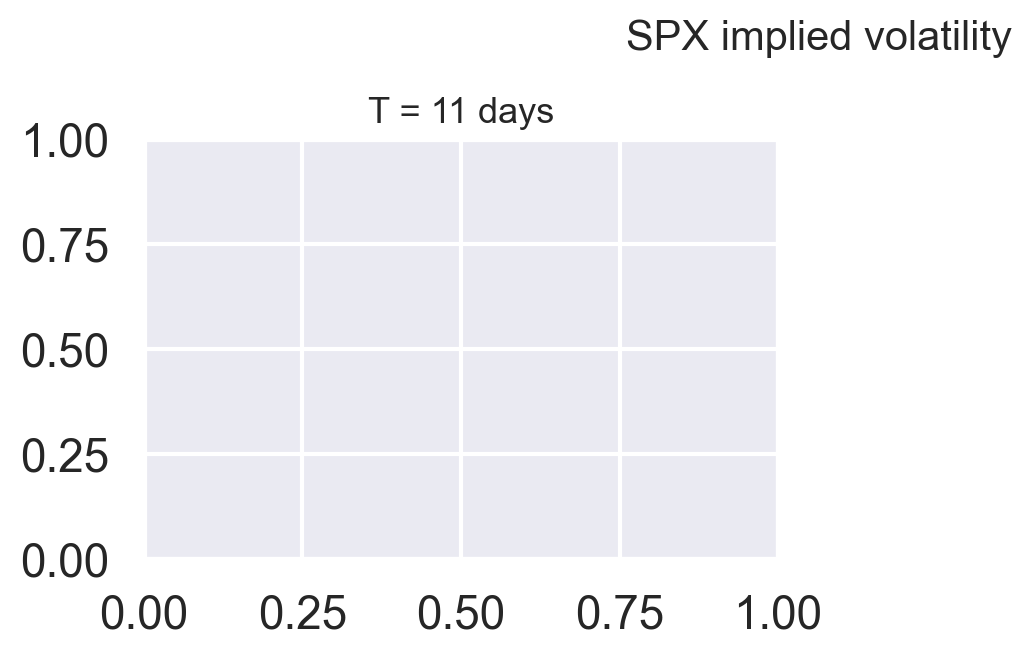

In [19]:
plt.figure(1, figsize=(9, 6))
counter = 1
for i in spx_maturities:
    plt.subplot(2, 2, counter)
    plt.suptitle("SPX implied volatility", fontsize=15)
    if counter == 1:
        plt.title(f"T = {int(np.round(i * 365, 0))} days", fontsize=13)

        lm_bd = quintic.spx_lm_range_rule(i)
        lms = np.linspace(lm_bd[0], lm_bd[1], 30)
        plt.plot(lms, spx_ivs[counter - 1], "g")
        plt.xlabel(r"log moneyness $\log(K/S_0)$", fontsize=12)
    else:
        plt.title(f"T = {int(np.round(i * 365, 0))} days", fontsize=13)

        lm_bd = quintic.spx_lm_range_rule(i)
        lms = np.linspace(lm_bd[0], lm_bd[1], 30)
        plt.plot(lms, spx_ivs[counter - 1], "g")

    counter += 1
plt.tight_layout()
plt.show()

In [ ]:
lm_vix = np.linspace(-0.1, 1, 50)
vix_strike_perc = np.exp(lm_vix)

In [21]:
vix_futs = []
vix_opts = []
vix_ivs = []
epochs_iter = tqdm(vix_maturities, desc="iteration", miniters=1)
for i in epochs_iter:
    vix_fut_temp, vix_opt_temp, vix_iv_temp = (
        quintic.vix_all_integration_poly_fast_revert_model(
            H,
            eps_fixed,
            i,
            a_k_part,
            x_org_vix,
            w_org_vix,
            vix_strike_perc,
            fvc,
            T_array_nodes,
        )
    )
    vix_futs.append(vix_fut_temp)
    vix_opts.append(vix_opt_temp)
    vix_ivs.append(vix_iv_temp)

NameError: name 'tqdm' is not defined

In [ ]:
plt.figure(1, figsize=(9, 6))
counter = 1
plt.suptitle("VIX implied volatility", fontsize=15)
for i in vix_maturities:
    plt.subplot(2, 2, counter)
    plt.title(f"T = {int(np.round(i * 365, 0))} days", fontsize=13)

    plt.plot(
        vix_strike_perc * vix_futs[counter - 1],
        vix_ivs[counter - 1],
        "g",
        label="VIX iv",
    )
    plt.axvline(x=vix_futs[counter - 1], color="green", label="VIX future calibration")
    # plt.legend()
    if counter == 1:
        plt.xlabel("strike", fontsize=12)
    counter += 1
plt.tight_layout()
# plt.savefig('calibration_vix_time_dependent.pdf')
plt.show()

In [ ]:
t_grids = np.linspace(0, T_array_nodes[-1], 20000)

In [24]:
spine_k_order = 3
fv_var_graph = interpolate.splrep(T_array_nodes, np.sqrt(fvc), k=spine_k_order)
fv_var_graph = (interpolate.splev(t_grids, fv_var_graph, der=0).reshape(-1, 1)) ** 2

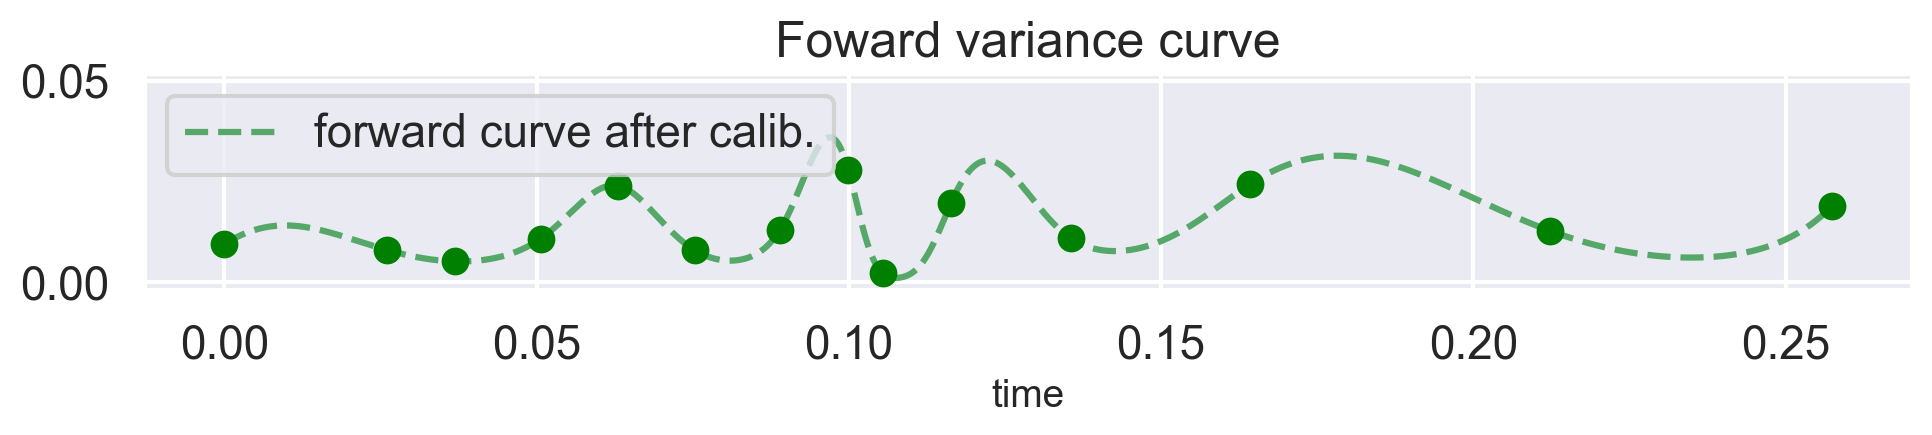

In [25]:
# shows what the Forward var looks like between 0 to T
plt.figure(1, figsize=(10, 2.5))
plt.title("Foward variance curve", y=1)
plt.plot(t_grids, fv_var_graph, "g--", label="forward curve after calib.")
plt.plot(T_array_nodes, fvc, "o", c="green")
plt.legend(loc="upper left")
plt.ylim(-0.002, 0.052)
plt.xlabel("time", fontsize=14)
plt.tight_layout()
# plt.savefig('fwd_var_curve.pdf')
plt.show()

## 5. Calibration results 2 slices SPX 1 slice VIX: based on the joint vol surface on 23/10/2017

Here we use a parametric forward variance curve defined as:
$$
  \xi_0(t) = a e^{-b t} + c(1-e^{-b t})
$$
with $a,b,c >0$.

In [ ]:
rho, H = -0.73157011, -0.13815974
eps_fixed = 1 / 52
a_k_part = np.array([0.81685253, 0.27397169, 0.17173771, 0.00360953])
a, b, c = 0.0084409, 2.04363437, 0.04406909
St = 100

In [ ]:
spx_maturities = np.array([0.02464116, 0.08213721])
vix_maturities = np.array([0.02464116])

In [ ]:
n_steps = 400
N_sims = 10000
np.random.seed(42)
w1_orig = quintic.gen_bm_path(n_steps, N_sims)
w1 = np.concatenate((np.zeros(w1_orig.shape[1])[np.newaxis, :], w1_orig))